# Interpreting the coefficients of a linear regression

A regression coefficient describes how much the response variable changes for a unit change of a covariate while all other covariates remain constant.

In this notebook, we will deepen this intuition with a hands-on example.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_context('poster')

## Generate data

We generate synthetic data using a form of structural equation modeling.
This way, we can check whether we are able to recover the coefficients.

In [3]:
N = 1000

beta_g1 = 1.4
beta_g2 = -0.8

mean_g1 = -2
mean_g2 = 10

In [4]:
np.random.seed(42)

X = np.random.normal(size=N * 2)
Y = np.r_[
    beta_g1 * X[: int(len(X) / 2)] + np.random.normal(mean_g1, size=N),
    beta_g2 * X[int(len(X) / 2) :] + np.random.normal(mean_g2, size=N),
]
group = ['$G_1$'] * N + ['$G_2$'] * N

In [5]:
df = pd.DataFrame({'X': X, 'Y': Y, 'group': group})

df['group'] = df['group'].astype('category')

df.head()

,X,Y,group
0,0.496714,-1.979778,$G_1$
1,-0.138264,-2.338089,$G_1$
2,0.647689,-1.885656,$G_1$
3,1.523030,-0.175720,$G_1$
4,-0.234153,-4.221429,$G_1$


## Fit model

The model:
$$
Y \sim \beta_0 + \beta_1 \cdot group + \beta_2 \cdot X + \beta_3 \cdot X \cdot group
$$

In [6]:
mod = smf.ols(formula='Y ~ X * group', data=df)
fit = mod.fit()

## Investigate result

### Retrieve coefficients

In [7]:
res = fit.summary()
res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.9946,0.032,-62.740,0.000,-2.057,-1.932
group[T.$G_2$],11.9799,0.045,266.149,0.000,11.892,12.068
X,1.4222,0.032,43.793,0.000,1.359,1.486
X:group[T.$G_2$],-2.2785,0.046,-50.067,0.000,-2.368,-2.189


In [8]:
coefs = fit.params
coefs

Intercept           -1.994595
group[T.$G_2$]      11.979866
X                    1.422225
X:group[T.$G_2$]    -2.278550
dtype: float64

### Understand their meaning

In [9]:
fitted_beta_g1 = coefs['X']
fitted_beta_g2 = coefs['X'] + coefs['X:group[T.$G_2$]']

fitted_mean_g1 = coefs['Intercept']
fitted_mean_g2 = coefs['Intercept'] + coefs['group[T.$G_2$]']

In [10]:
pd.DataFrame(
    {
        'label': ['beta_g1', 'beta_g2', 'mean_g1', 'mean_g2'],
        'true_value': [beta_g1, beta_g2, mean_g1, mean_g2],
        'fitted_value': [
            fitted_beta_g1,
            fitted_beta_g2,
            fitted_mean_g1,
            fitted_mean_g2,
        ],
    }
)

,label,true_value,fitted_value
0,beta_g1,1.4,1.422225
1,beta_g2,-0.8,-0.856325
2,mean_g1,-2.0,-1.994595
3,mean_g2,10.0,9.985271


In [11]:
def annotate_plot(space, mean, beta, color):
    values = mean + beta * space

    ax.plot(space, values, color=color)
    ax.axhline(mean, ls='dashed', color=color)

    mid = len(space) // 2
    ax.text(
        space[mid],
        values[mid],
        f'${mean:.2f} + {beta:.2f} \cdot x$',
        color=color,
        size=12,
        bbox=dict(boxstyle='round4,pad=.5', fc='0.85'),
        ha='center',
    )

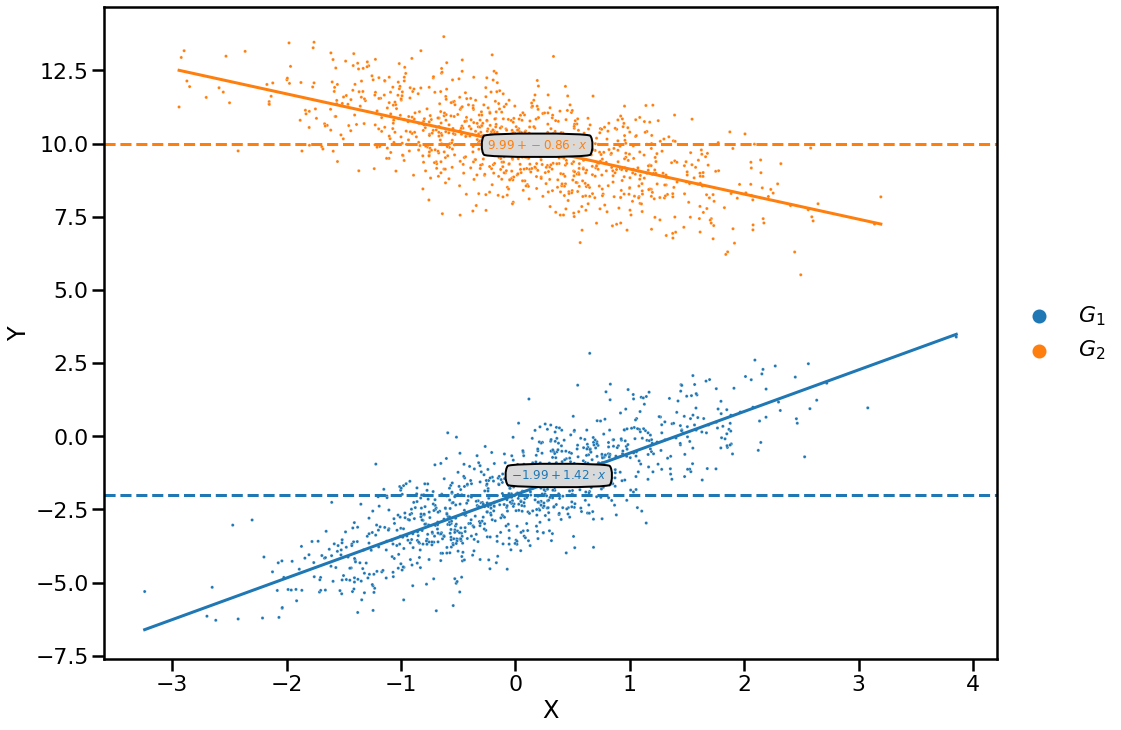

In [12]:
plt.figure(figsize=(16, 12))
ax = sns.scatterplot(x='X', y='Y', hue='group', data=df, s=10)

sub = df.loc[df['group'] == '$G_1$', 'X']
annotate_plot(
    np.linspace(sub.min(), sub.max()),
    fitted_mean_g1,
    fitted_beta_g1,
    sns.color_palette()[0],
)

sub = df.loc[df['group'] == '$G_2$', 'X']
annotate_plot(
    np.linspace(sub.min(), sub.max()),
    fitted_mean_g2,
    fitted_beta_g2,
    sns.color_palette()[1],
)

plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)